In [1]:
!pip install keras-cv

In [2]:
!pip install --upgrade keras-cv

^C


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0, MobileNetV2, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization, Concatenate, Reshape
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Conv2DTranspose
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import pathlib
import os
import datetime
import time
import keras_cv

In [21]:
!pip list

Package                               Version
------------------------------------- ------------------
absl-py                               1.4.0
accelerate                            1.6.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.23
albumentations                        2.0.5
ale-py                                0.10.2
altair                                5.5.0
annotated-types                       0.7.0
anyio                                 4.9.0
argon2-cffi                           23.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.1
arviz                                 0.21.0
astropy                               7.0.1
astropy-iers-data                     0.2025.4.21.0.37.6
astunparse                            1.6.3
atpublic                              5.1

In [2]:
# 1. 라이브러리 및 데이터 준비
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd

# 데이터셋 다운로드 및 준비
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

# 현재 데이터 경로 확인
print("데이터셋 경로:", data_dir)

# 폴더 구조 확인 (문제 파악용)
print("폴더 내 항목:", [item.name for item in data_dir.glob('*')])

# 실제 꽃 이미지가 있는 폴더로 경로 수정
if 'flower_photos' in [item.name for item in data_dir.glob('*')]:
    data_dir = data_dir / 'flower_photos'
    print("수정된 데이터셋 경로:", data_dir)

# 클래스 확인
flowers_classes = [item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]
print("꽃 종류:", flowers_classes)
print("클래스 수:", len(flowers_classes))

# 이미지 개수 확인
image_count = len(list(data_dir.glob('*/*.jpg')))
print("전체 이미지 개수:", image_count)

# 클래스별 이미지 개수 확인
for flower in flowers_classes:
    flower_count = len(list(data_dir.glob(f'{flower}/*.jpg')))
    print(f"{flower}: {flower_count}개")

batch_size = 32
img_height = 128
img_width = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
class_names = train_ds.class_names
num_classes = len(class_names)

# 데이터 증강 및 전처리
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])
normalization_layer = layers.Rescaling(1./255)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
데이터셋 경로: /root/.keras/datasets/flower_photos
폴더 내 항목: ['flower_photos']
수정된 데이터셋 경로: /root/.keras/datasets/flower_photos/flower_photos
꽃 종류: ['sunflowers', 'tulips', 'daisy', 'roses', 'dandelion']
클래스 수: 5
전체 이미지 개수: 3670
sunflowers: 699개
tulips: 799개
daisy: 633개
roses: 641개
dandelion: 898개
Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


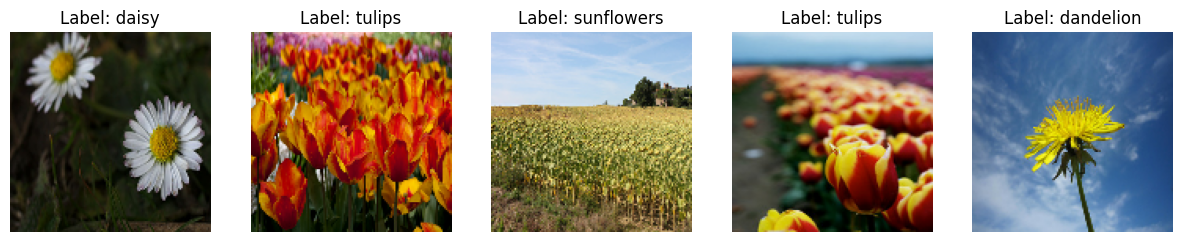

In [4]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

normalization_layer = layers.Rescaling(1./255)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

plt.figure(figsize=(15, 5))
for images, labels in train_ds.take(1):  # 첫 배치에서 5장만 출력
    for i in range(5):
        ax = plt.subplot(1, 5, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {class_names[labels[i]]}")
        plt.axis("off")
plt.show()

In [5]:
def build_resnet50():
    base = keras.applications.ResNet50(
        input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
    base.trainable = False
    model = keras.Sequential([
        data_augmentation,
        normalization_layer,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_efficientnet():
    base = keras.applications.EfficientNetB0(
        input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
    base.trainable = False
    model = keras.Sequential([
        data_augmentation,
        normalization_layer,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_densenet():
    base = keras.applications.DenseNet121(
        input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
    base.trainable = False
    model = keras.Sequential([
        data_augmentation,
        normalization_layer,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_mobilenet():
    base = keras.applications.MobileNetV2(
        input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
    base.trainable = False
    model = keras.Sequential([
        data_augmentation,
        normalization_layer,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# vit

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = Dense(units, activation=tf.nn.gelu)(x)
        x = Dropout(dropout_rate)(x)
    return x

def build_vit_model():
    input_shape = (img_height, img_width, 3)
    patch_size = 16
    num_patches = (img_height // patch_size) * (img_width // patch_size)
    projection_dim = 64
    num_heads = 4
    transformer_units = [
        projection_dim * 2,
        projection_dim,
    ]
    transformer_layers = 8
    mlp_head_units = [1024, 512]

    inputs = Input(shape=input_shape)

    # 패치 추출을 Lambda로 감싸기
    patches = Lambda(lambda images: tf.image.extract_patches(
        images=images,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID"
    ))(inputs)

    patch_dims = patches.shape[-1]

    # 패치 Reshape도 Lambda로 감싸기
    patches = Lambda(lambda x: tf.reshape(x, (-1, num_patches, patch_dims)))(patches)

    patch_encoding = Dense(projection_dim)(patches)

    # 위치 임베딩 추가
    positions = tf.range(start=0, limit=num_patches, delta=1)
    position_embedding = Embedding(input_dim=num_patches, output_dim=projection_dim)(positions)
    encoded_patches = patch_encoding + position_embedding

    # Transformer 블록 구성
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = LayerNormalization(epsilon=1e-6)(encoded_patches)

        attention_output = MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1
        x2 = tf.keras.layers.add([attention_output, encoded_patches])

        # Layer normalization 2
        x3 = LayerNormalization(epsilon=1e-6)(x2)

        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2
        encoded_patches = tf.keras.layers.add([x3, x2])

    # Layer normalization
    representation = LayerNormalization(epsilon=1e-6)(encoded_patches)

    # Global average pooling
    representation = tf.keras.layers.GlobalAveragePooling1D()(representation)

    # MLP 헤드
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.1)

    # 분류를 위한 최종 레이어
    logits = Dense(len(flowers_classes), activation="softmax")(features)

    # 모델 생성
    model = Model(inputs=inputs, outputs=logits)

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # Change to SparseCategoricalCrossentropy
        metrics=["accuracy"],
    )

    return model

def build_attention_cnn():
    # 간단한 Self-Attention Layer 추가 CNN
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = data_augmentation(inputs)
    x = normalization_layer(x)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.LayerNormalization()(x)
    # MultiHeadAttention
    # Instead of using tf.shape directly, get the shape within a Lambda layer
    # and use tf.keras.backend.int_shape to get static shape information.
    shape = tf.keras.backend.int_shape(x)
    x = layers.Reshape((shape[1] * shape[2], shape[3]))(x)
    x = layers.MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_unet_classifier():
    # U-Net 기반 분류기 (Encoder만 사용)
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = data_augmentation(inputs)
    x = normalization_layer(x)
    # Encoder
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    p1 = layers.MaxPooling2D((2,2))(c1)
    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D((2,2))(c2)
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(p2)
    p3 = layers.MaxPooling2D((2,2))(c3)
    x = layers.GlobalAveragePooling2D()(p3)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model_builders = {
    "ResNet50": build_resnet50,
    "EfficientNetB0": build_efficientnet,
    "DenseNet121": build_densenet,
    "MobileNetV2": build_mobilenet,
    "ViT": build_vit_model,
    "Attention-CNN": build_attention_cnn,
    "U-Net-Classifier": build_unet_classifier,
}

results = []
EPOCHS = 5

for name, builder in model_builders.items():
    print(f"Training {name} ...")
    model = builder()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose=2
    )
    val_acc = max(history.history['val_accuracy'])
    results.append({"Model": name, "Best Val Accuracy": val_acc})

# 4. 결과 비교 표 출력
results_df = pd.DataFrame(results)
display(results_df)

# 5. 성능 시각화
results_df.plot(kind='bar', x='Model', y='Best Val Accuracy', legend=False)
plt.title("Comparison of flower classification performance by model")
plt.ylabel("Validation Accuracy")
plt.ylim(0, 1)
plt.show()

In [ ]:
model_builders = {
    "ResNet50": build_resnet50,
    "EfficientNetB0": build_efficientnet,
    "DenseNet121": build_densenet,
    "MobileNetV2": build_mobilenet,
    "ViT": build_vit_model,
    "Attention-CNN": build_attention_cnn,
    "U-Net-Classifier": build_unet_classifier,
}

results = []
EPOCHS = 5

import matplotlib.pyplot as plt
# 모델별 결과 시각화
for name, builder in model_builders.items():
    print(f"Evaluating and plotting {name} ...")
    model = builder()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose=0
    )

    # 모델 평가
    model_res = model.evaluate(val_ds, verbose=0)
    print(f'{name} 모델 정확도 = {model_res[1]*100}')

    # 모델 정확도/손실 그래프
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} Accuracy Graph')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'])
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{name} Loss Graph')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'])
    plt.grid()
    plt.show()


# 4. 결과 비교 표 출력
results_df = pd.DataFrame(results)
display(results_df)

# 5. 성능 시각화
results_df.plot(kind='bar', x='Model', y='Best Val Accuracy', legend=False)
plt.title("Comparison of flower classification performance by model")
plt.ylabel("Validation Accuracy")
plt.ylim(0, 1)
plt.show()

Evaluating and plotting ResNet50 ...
ResNet50 모델 정확도 = 39.65%


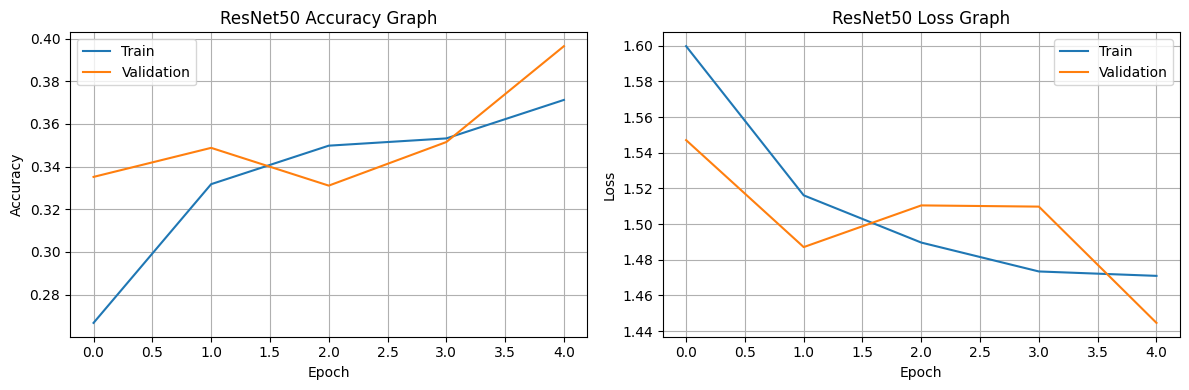

Evaluating and plotting EfficientNetB0 ...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
EfficientNetB0 모델 정확도 = 23.98%


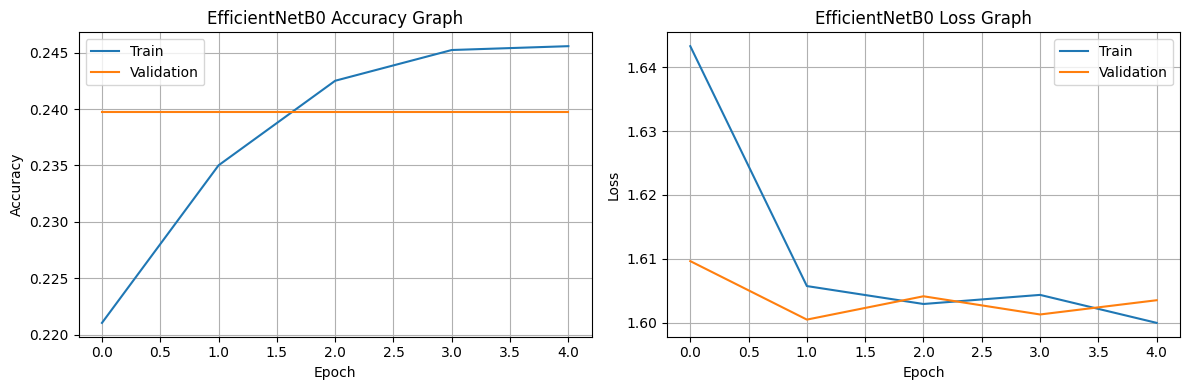

Evaluating and plotting DenseNet121 ...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
DenseNet121 모델 정확도 = 87.33%


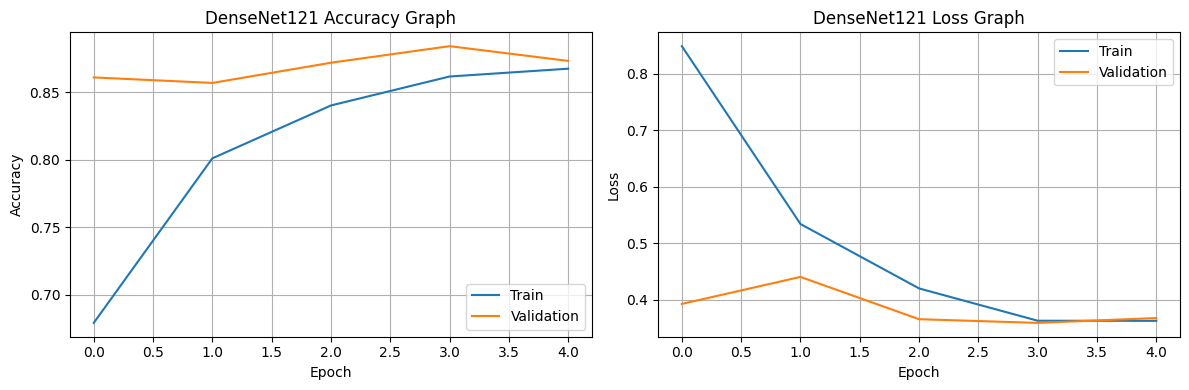

Evaluating and plotting MobileNetV2 ...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MobileNetV2 모델 정확도 = 86.92%


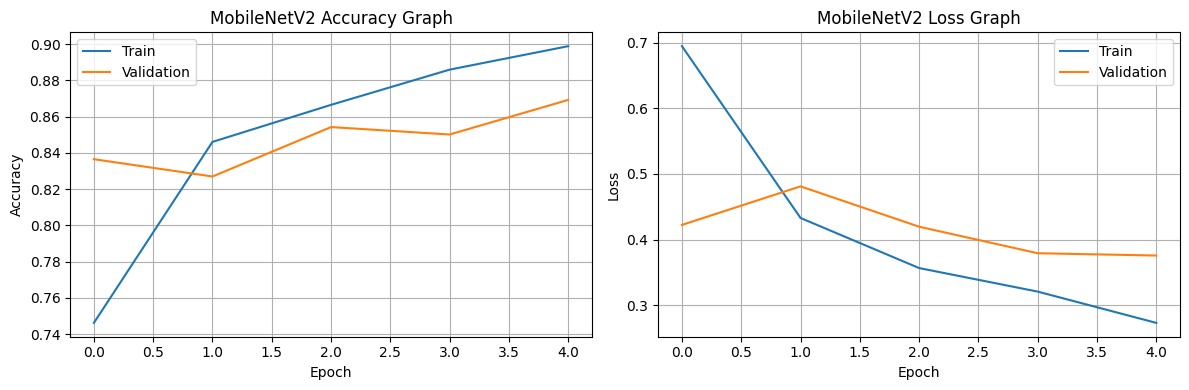

Evaluating and plotting ViT ...
ViT 모델 정확도 = 48.91%


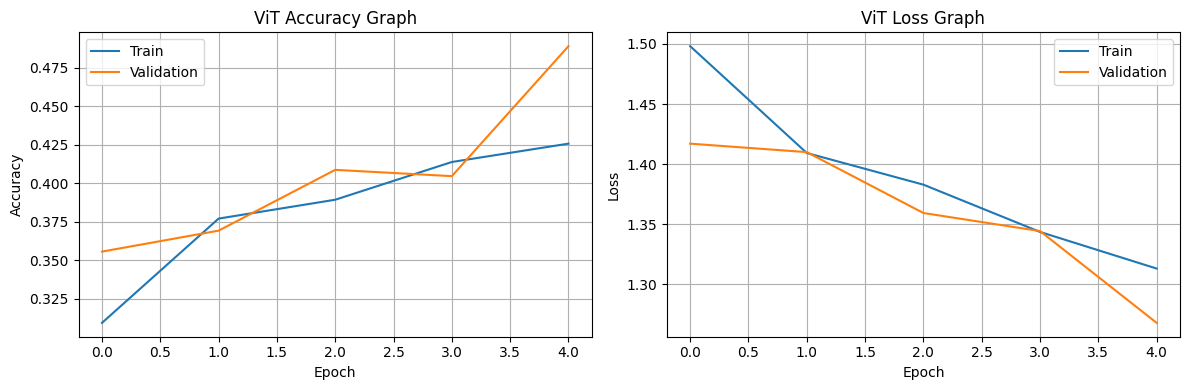

Evaluating and plotting Attention-CNN ...
Attention-CNN 모델 정확도 = 65.40%


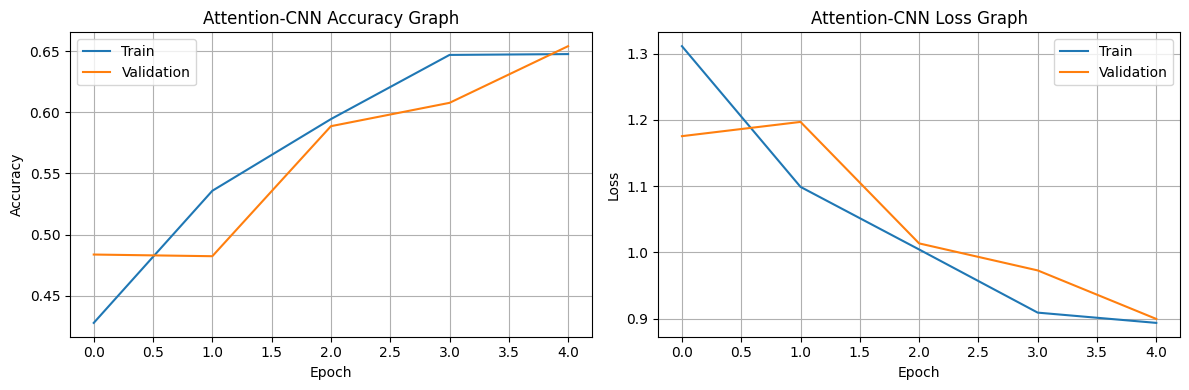

Evaluating and plotting U-Net-Classifier ...
U-Net-Classifier 모델 정확도 = 56.27%


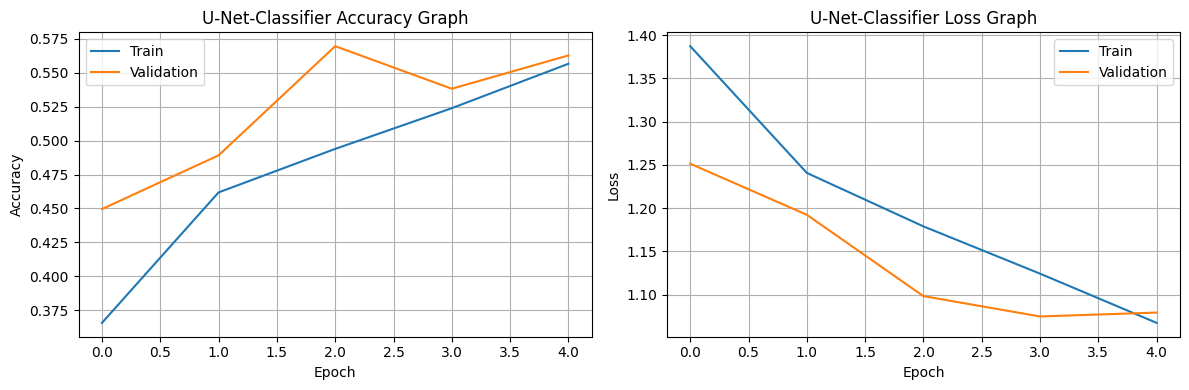


모델 성능 비교 테이블:
              모델   정확도 (%)       손실  총 파라미터 수  훈련 가능한 파라미터  훈련 시간 (초)
        ResNet50 39.645776 1.444644  24113541       525829  49.544590
  EfficientNetB0 23.978202 1.603531   4378792       329221  29.699478
     DenseNet121 87.329698 0.367609   7301189       263685  50.265310
     MobileNetV2 86.920983 0.375672   2587205       329221  18.624615
             ViT 48.910081 1.267903   1308869      1308869  85.638579
   Attention-CNN 65.395093 0.899434     45125        45125  27.853313
U-Net-Classifier 56.267029 1.079411    110405       110405  13.699587


<ipython-input-8-1a15d08a273c>:125: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-8-1a15d08a273c>:125: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-8-1a15d08a273c>:125: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-8-1a15d08a273c>:125: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-8-1a15d08a273c>:125: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-8-1a15d08a273c>:125: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-8-1a15d08a273c>:125: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipy

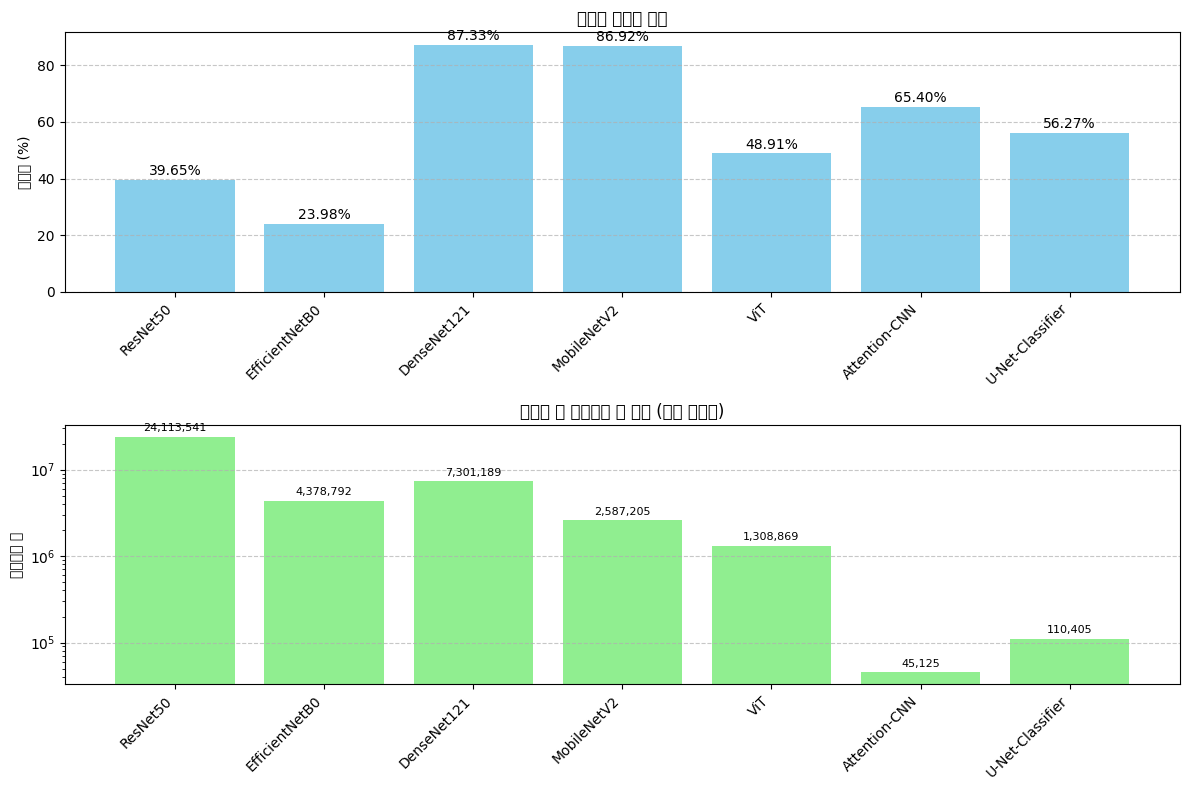

<ipython-input-8-1a15d08a273c>:145: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-8-1a15d08a273c>:145: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-8-1a15d08a273c>:145: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-8-1a15d08a273c>:145: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-8-1a15d08a273c>:145: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-8-1a15d08a273c>:145: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-8-1a15d08a273c>:145: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-i

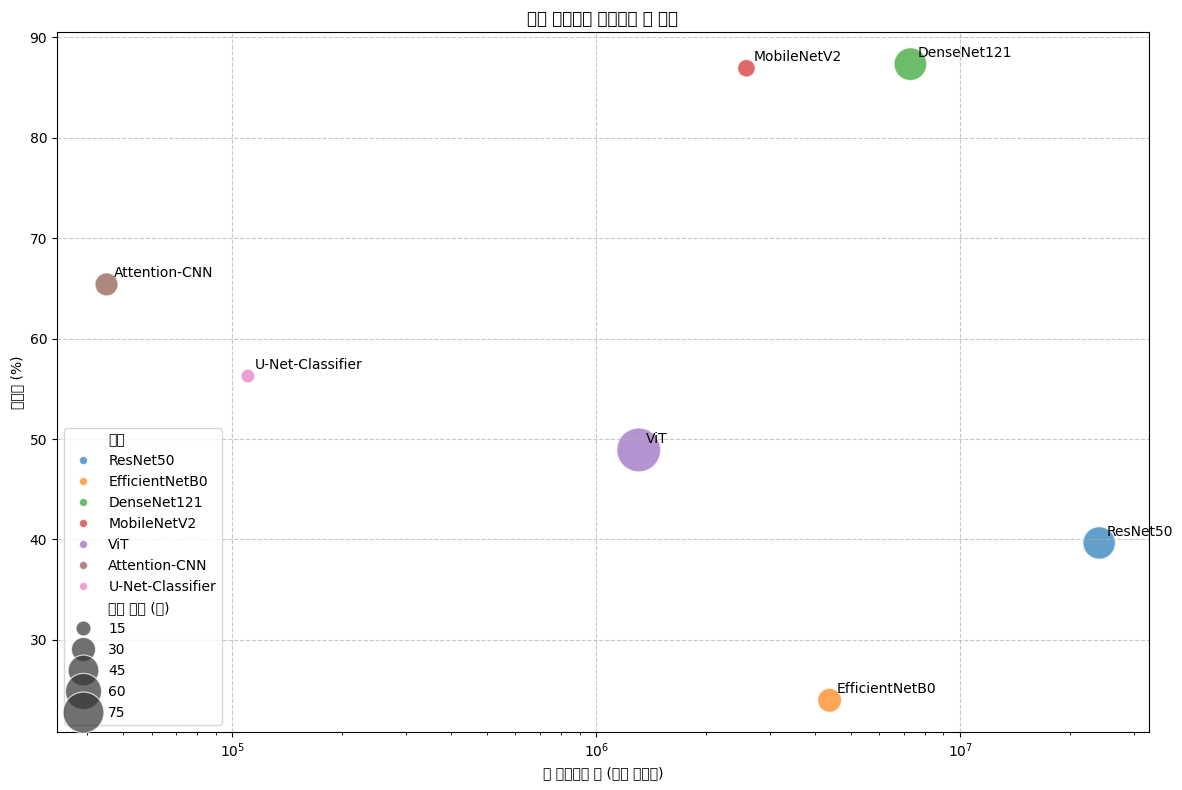


최고 정확도 모델:
모델: DenseNet121
정확도: 87.33%
총 파라미터 수: 7,301,189

가장 작은 파라미터 모델:
모델: Attention-CNN
정확도: 65.40%
총 파라미터 수: 45,125

모델 평가 결과 요약:
1. 정확도 기준 상위 3개 모델:
   DenseNet121: 87.33%, 파라미터 수: 7,301,189
   MobileNetV2: 86.92%, 파라미터 수: 2,587,205
   Attention-CNN: 65.40%, 파라미터 수: 45,125

2. 파라미터 수 기준 상위 3개 모델 (가장 작은 순):
   Attention-CNN: 45,125 파라미터, 정확도: 65.40%
   U-Net-Classifier: 110,405 파라미터, 정확도: 56.27%
   ViT: 1,308,869 파라미터, 정확도: 48.91%

3. 파라미터 대비 정확도가 가장 좋은 모델 (정확도/log(파라미터)):
   Attention-CNN: 효율성 점수: 14.05, 정확도: 65.40%, 파라미터 수: 45,125


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time

model_builders = {
    "ResNet50": build_resnet50,
    "EfficientNetB0": build_efficientnet,
    "DenseNet121": build_densenet,
    "MobileNetV2": build_mobilenet,
    "ViT": build_vit_model,
    "Attention-CNN": build_attention_cnn,
    "U-Net-Classifier": build_unet_classifier,
}

results = []
all_results = []
EPOCHS = 5

# 모델별 훈련 및 평가
for name, builder in model_builders.items():
    print(f"Evaluating and plotting {name} ...")
    model = builder()

    # Build the model by calling it with a dummy input
    dummy_input = tf.zeros((1, img_height, img_width, 3)) # Create a dummy input with the correct shape
    _ = model(dummy_input) # Call the model with the dummy input to build it

    total_params = model.count_params()
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_variables])

    start_time = time.time()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose=0
    )
    training_time = time.time() - start_time

    model_res = model.evaluate(val_ds, verbose=0)
    test_loss, test_accuracy = model_res[0], model_res[1]

    print(f'{name} 모델 정확도 = {test_accuracy * 100:.2f}%')

    # 결과 저장
    all_results.append({
        'model_name': name,
        'test_accuracy': test_accuracy * 100,
        'test_loss': test_loss,
        'total_params': total_params,
        'trainable_params': trainable_params,
        'training_time': training_time
    })

    # 학습 그래프
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} Accuracy Graph')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'])
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{name} Loss Graph')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'])
    plt.grid()

    plt.tight_layout()
    plt.show()

#===================================== 모델 성능 비교 및 시각화

# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame([{
    '모델': r['model_name'],
    '정확도 (%)': r['test_accuracy'],
    '손실': r['test_loss'],
    '총 파라미터 수': r['total_params'],
    '훈련 가능한 파라미터': r['trainable_params'],
    '훈련 시간 (초)': r['training_time']
} for r in all_results])

# 결과 테이블 출력
print("\n모델 성능 비교 테이블:")
print(results_df.to_string(index=False))

# 정확도 비교 그래프
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
accuracy_bar = plt.bar(results_df['모델'], results_df['정확도 (%)'], color='skyblue')
plt.title('모델별 정확도 비교')
plt.ylabel('정확도 (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in accuracy_bar:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.2f}%', ha='center', va='bottom', fontsize=10)

# 파라미터 수 비교
plt.subplot(2, 1, 2)
param_bar = plt.bar(results_df['모델'], results_df['총 파라미터 수'], color='lightgreen')
plt.title('모델별 총 파라미터 수 비교 (로그 스케일)')
plt.ylabel('파라미터 수')
plt.yscale('log')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in param_bar:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height * 1.1,
             f'{height:,.0f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# 정확도-파라미터 관계 산점도
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='총 파라미터 수', y='정확도 (%)', data=results_df,
    size='훈련 시간 (초)', hue='모델', sizes=(100, 1000), alpha=0.7
)
plt.xscale('log')
plt.title('모델 정확도와 파라미터 수 관계')
plt.xlabel('총 파라미터 수 (로그 스케일)')
plt.ylabel('정확도 (%)')
plt.grid(linestyle='--', alpha=0.7)

for i, row in results_df.iterrows():
    plt.annotate(row['모델'],
                 (row['총 파라미터 수'], row['정확도 (%)']),
                 xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

# 최적 모델 선정
max_accuracy_model = results_df.loc[results_df['정확도 (%)'].idxmax()]
min_params_model = results_df.loc[results_df['총 파라미터 수'].idxmin()]

print("\n최고 정확도 모델:")
print(f"모델: {max_accuracy_model['모델']}")
print(f"정확도: {max_accuracy_model['정확도 (%)']:.2f}%")
print(f"총 파라미터 수: {max_accuracy_model['총 파라미터 수']:,}")

print("\n가장 작은 파라미터 모델:")
print(f"모델: {min_params_model['모델']}")
print(f"정확도: {min_params_model['정확도 (%)']:.2f}%")
print(f"총 파라미터 수: {min_params_model['총 파라미터 수']:,}")

# 평가 결과 요약
print("\n모델 평가 결과 요약:")
print("1. 정확도 기준 상위 3개 모델:")
top_accuracy = results_df.sort_values(by='정확도 (%)', ascending=False).head(3)
for _, row in top_accuracy.iterrows():
    print(f"   {row['모델']}: {row['정확도 (%)']:.2f}%, 파라미터 수: {row['총 파라미터 수']:,}")

print("\n2. 파라미터 수 기준 상위 3개 모델 (가장 작은 순):")
top_params = results_df.sort_values(by='총 파라미터 수').head(3)
for _, row in top_params.iterrows():
    print(f"   {row['모델']}: {row['총 파라미터 수']:,} 파라미터, 정확도: {row['정확도 (%)']:.2f}%")

print("\n3. 파라미터 대비 정확도가 가장 좋은 모델 (정확도/log(파라미터)):")
results_df['효율성'] = results_df['정확도 (%)'] / np.log10(results_df['총 파라미터 수'])
top_efficiency = results_df.sort_values(by='효율성', ascending=False).head(1)
for _, row in top_efficiency.iterrows():
    print(f"   {row['모델']}: 효율성 점수: {row['효율성']:.2f}, 정확도: {row['정확도 (%)']:.2f}%, 파라미터 수: {row['총 파라미터 수']:,}")
